# 준비 과정

# 새 섹션

## 구글 드라이브 연동

In [1]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 구글 드라이브 파일 확인
!ls '/gdrive/My Drive/project/'

# 반복되는 드라이브 경로 변수화
drive_path = '/gdrive/My Drive/project/'

Mounted at /gdrive
'서울시 사설학원 및 독서실 통계 (2015-2019).txt'   sns2018_1.csv
 서울특별시_부동산_실거래가_정보_2017년.csv	   sns2018_2.csv
 농가판매가격지수2018.csv			   sns2019_1.csv
 20190401기준_학교일람표.xlsx			   sns2019_2.csv
 농가판매가격지수2019.csv			   table2018.csv
 buy2018_1.csv					   table2018.txt
 buy2018_2.csv					   table2019.csv
 buy2019_1.csv					   table2019.txt
 buy2019_2.csv					   total_data_2.csv
 report.txt					   total_data.csv
 school.csv


## 한글 폰트 설정

In [2]:
!apt -qq -y install fonts-nanum
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


## 라이브러리 호출

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# 랜덤포레스트

import warnings
warnings.filterwarnings("ignore")

## 사용할 데이터

In [4]:
# 데이터 가져오기
df_buy = pd.read_csv(drive_path + "buy2018_1.csv")
df_buy2 = pd.read_csv(drive_path + "buy2018_2.csv")
df_weather = pd.read_csv(drive_path + 'table2018.txt')
df_weather = pd.read_csv(drive_path + 'table2018.txt')

### 2018 구매 데이터  
상반기, 하반기 구매 데이터 통합

In [5]:
buy2018_col = ['Unnamed', 'buy2018.date', 'buy2018.sex', 'buy2018.age', 'buy2018.big_cat', 'buy2018.sm_cat', 'buy2018.qty']

# 통합하기 위해 col 맞춰주기
buy_columns = list(df_buy.columns)

df_buy.columns = buy2018_col
df_buy2.columns = buy2018_col

# 데이터 통합하기
buy_data2018 = pd.concat([df_buy, df_buy2], ignore_index=True)

df_buy, df_buy2, buy_data2018

(        Unnamed  buy2018.date  ... buy2018.sm_cat  buy2018.qty
 0             1      20180101  ...            가공란           37
 1             2      20180101  ...            가공란           16
 2             3      20180101  ...            가공란            9
 3             4      20180101  ...            가공란            3
 4             5      20180101  ...            가공란           13
 ...         ...           ...  ...            ...          ...
 498005   498006      20180630  ...             히터            2
 498006   498007      20180630  ...             히터            2
 498007   498008      20180630  ...             히터            1
 498008   498009      20180630  ...             히터            2
 498009   498010      20180630  ...             히터            1
 
 [498010 rows x 7 columns],
         Unnamed  buy2018.date  ... buy2018.sm_cat  buy2018.qty
 0             1      20180701  ...            가공란           28
 1             2      20180701  ...            가공란           47
 2        

### 날짜 데이터 변환  
2018 구매 데이터, 날씨 데이터 날짜 포맷 통일 시키기 위해

In [6]:
# 날짜 데이터 변환
# 구매 데이터
buy_data2018['buy2018.date'] = buy_data2018['buy2018.date'].astype(str)
buy_data2018['buy2018.date'] = pd.to_datetime(buy_data2018['buy2018.date'])

# 날씨 데이터
df_weather['tma'] = df_weather['tma'].astype(str)
df_weather['tma'] = pd.to_datetime(df_weather['tma'])

# day_range에 날짜 데이터 저장
day_range = buy_data2018['buy2018.date'].astype(str).unique()

# 날씨 데이터 변환
# 날짜순 정렬
df_weather.sort_values(by='tma', axis=0, inplace=True)

# Unnamed 재정렬
df_weather['Unnamed: 0'] = [i for i in range(len(df_weather))]
df_weather.reset_index(drop=True, inplace=True)

# 강수량, 일 적설량 NaN -> 0 으로 치환
df_weather['sum_rn'].fillna(0, inplace=True)
df_weather['dd_mes'].fillna(0, inplace=True)

In [7]:
# 필요없는 열 삭제
df_weather = df_weather.drop(columns=['stn_id', 'avg_tca','avg_lmac', 'max_ca', 'avg_ts', 'sum_fog_dur', 'avg_pa', 'avg_td'], axis=1)

### 불쾌지수 데이터 생성

In [8]:
# 불쾌지수 계산
# 식 : 1.8*기온-0.55*(1-습도)*(1.8*기온-26)+32
result = pd.DataFrame(data=range(len(day_range)), columns=['불쾌지수'], index=day_range)

for day in day_range:
  data = df_weather[df_weather['tma'] == day]
  
  value = 1.8 * data['avg_ta'] - (0.55 * (1 - data['avg_rhm'] * 0.01) * (1.8 * data['avg_ta'] - 26)) + 32
  result.loc[day]['불쾌지수'] = value
discomfort = pd.DataFrame(result)

# 단계 분류
bins = [20, 67, 74, 79, 85] # 초과, 이하
labels = ['낮음', '보통', '높음', '매우높음'] # 0 ~ 3이나 1 ~ 4 이런 식
discomfort['단계'] = pd.cut(discomfort['불쾌지수'], bins=bins, labels=labels)

discomfort

,불쾌지수,단계
2018-01-01,39,낮음
2018-01-02,38,낮음
2018-01-03,34,낮음
2018-01-04,34,낮음
2018-01-05,35,낮음
...,...,...
2018-12-27,31,낮음
2018-12-28,29,낮음
2018-12-29,33,낮음
2018-12-30,33,낮음


In [9]:
# 날씨 데이터에 불쾌지수 열 추가
for day in day_range:
  data = df_weather[df_weather['tma'] == day]
  df_weather['discomfort'] = discomfort[discomfort.index == day]['단계'][0]

df_weather

,Unnamed: 0,tma,avg_ta,max_ta,min_ta,avg_rhm,min_rhm,avg_ws,sum_rn,dd_mes,discomfort
0,0,2018-01-01,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
1,1,2018-01-02,-1.8,1.8,-4.3,42.0,19,1.8,0.0,0.0,낮음
2,2,2018-01-03,-4.7,-0.4,-7.1,42.3,28,2.2,0.0,0.0,낮음
3,3,2018-01-04,-4.7,-0.7,-8.7,43.0,31,1.4,0.0,0.0,낮음
4,4,2018-01-05,-3.0,1.6,-5.6,48.4,32,1.7,0.0,0.0,낮음
...,...,...,...,...,...,...,...,...,...,...,...
360,360,2018-12-27,-10.1,-6.5,-12.5,28.3,16,3.5,0.0,0.0,낮음
361,361,2018-12-28,-10.5,-6.6,-14.4,33.0,23,2.5,0.0,0.0,낮음
362,362,2018-12-29,-7.6,-3.0,-10.5,29.0,18,2.9,0.0,0.0,낮음
363,363,2018-12-30,-6.8,-0.9,-11.3,35.9,23,1.2,0.0,0.0,낮음


### 2018 식품 데이터 중분류 추가

In [10]:
# 식품 중분류
array = {'가공란':'가공식품', '가자미':'수산물', '갈비/찜/바비큐용 돈육':'육류', 
       '갈비용 우육':'육류', '갈치':'수산물', '감/홍시':'과일', '감귤/한라봉/오렌지':'과일',
       '감마리놀렌산 영양제':'건강식품', '감말랭이':'건과', '감자':'채소', '갓김치':'김치',
       '건강즙':'건강식품', '건강즙/녹용':'건강식품', '건대추':'건과', '건망고':'건과',
       '건바나나':'건과', '건어물 건새우':'건어물', '건어물 노가리':'건어물', '건어물 마른오징어':'건어물', 
       '건어물 멸치':'건어물', '건어물 쥐포':'건어물',
       '건어물 진미채':'건어물', '건어물 황태':'건어물', '건자두':'건과', 
       '건포도':'건과', '게장류':'반찬', '견과류':'견과', '견과류 땅콩':'견과',
       '견과류 마카다미아':'견과', '견과류 밤':'견과', '견과류 잣/은행':'견과', 
       '견과류 카카오닙스':'견과', '견과류 캐슈넛':'견과','견과류 피스타치오':'견과', '견과류 호두':'견과', 
       '계란':'알류', '고등어':'수산물', '고추/피망/파프리카':'채소', '곡물차':'음료', '곶감/반건시':'건과',
       '과실차':'음료', '과일류':'과일', '과일세트':'과일', '과채 음료/주스':'음료', 
       '국내산 돈육':'육류', '굴 생물':'수산물', '굴비/조기':'수산물',
       '글루코사민/키토산 영양제':'건강식품', '기타 농산물':'채소', '기타 주스류':'음료', 
       '기타 한방/환제품':'건강식품', '김치류':'김치', '꽃게':'수산물',
       '나물':'채소', '낙지':'수산물', '녹차':'음료', '느타리버섯':'채소류', 
       '다이어트보조식':'건강식품', '다이어트용 헬스보충식품':'건강식품', '닭 양념육':'육류',
       '닭가슴살':'육류', '대게/킹크랩':'수산물', '더치커피':'음료', '도라지/더덕':'채소', 
       '돼지 곱창':'육류', '두유':'음료', '둥굴레차':'음료',
       '딸기/복분자/블루베리':'과일', '딸기우유':'음료', '랍스타':'수산물', 
       '레몬/자몽':'과일', '루테인/눈 영양제':'건강식품', '마/야콘':'채소',
       '마늘/생강':'채소', '메추리알':'알류', '명태/동태':'수산물', '무/배추':'채소', 
       '무김치':'김치', '문어':'수산물', '물김치':'김치', '미나리':'채소',
       '미숫가루/곡물가루':'분말가루', '믹스 채소':'채소', '밀크티/티라떼':'음료', 
       '바나나/파인애플/망고':'과일', '바나나우유':'음료', '반건조고구마':'가공식품',
       '반찬류':'반찬', '배/포도/과일즙':'과일', '배추김치':'김치', '백김치':'김치', '보리차':'음료', 
       '복분자/석류/과실즙':'음료', '부추':'채소',
       '브로콜리/셀러리':'채소', '비타민':'건강식품', '비타민/화이바 음료':'음료', 
       '삼치':'수산물', '상황버섯':'채소', '새송이버섯':'채소', '새우/대하':'수산물',
       '생닭/닭부분육':'육류', '생선류':'수산물', '생수':'음료', '생식/선식 분말':'선식류', '선식':'선식류', 
       '소고기 등심/안심':'육류', '소고기 육회':'육류',
       '수산 생물':'수산물', '수입우육':'육류', '숙취/에너지/건강 음료':'음료', 
       '스피루리나 영양제':'건강식품', '시금치':'채소', '식혜/수정과':'음료', '쌀':'곡류',
       '쌈채소':'채소', '아몬드유/코코넛밀크':'음료', '아이스티':'음료', '야채/호박즙':'건강식품', 
       '양념 돈육':'육류', '양념우육':'육류', '양배추/양상추':'채소',
       '양파/마늘즙':'건강식품', '어란(생선알)':'수산물', '어린이 음료':'음료', '어린이영양제':'건강식품', 
       '어린이홍삼':'건강식품', '어린잎/새싹채소':'채소',
       '에이드':'음료', '연어/훈제연어':'수산물', '영지버섯':'채소', '오리고기/훈제오리':'육류', 
       '오메가3/스쿠알렌 영양제':'건강식품', '오이/가지':'채소',
       '오징어':'수산물', '옥돔':'수산물', '옥수수':'채소', '옥수수차':'음료', '옻/칡/쑥즙':'건강식품', 
       '요거트/발효유':'가공식품', '우엉/연근':'채소', '원두커피':'홈카페',
       '윙봉/닭다리/날개':'육류', '유자차':'음료', '유제품 음료':'음료', '율무차':'음료', 
       '음용 식초':'음료', '이온음료':'음료', '인삼/수삼/산삼':'채소',
       '인스턴트커피':'홈카페', '잡곡':'곡류', '잡곡 씨드류':'곡류', '장어':'수산물', 
       '장조림/카레용 돈육':'육류', '저/무지방우유':'음료', '전복 생물':'수산물',
       '전통주':'음료', '전통차':'음료', '절임배추/김치속':'김치', '젓갈류':'반찬', '조개':'수산물', 
       '주꾸미':'수산물', '차 선물세트':'음료', '차/곡물 음료':'음료',
       '참외/메론/수박':'과일', '초유 영양제':'건강식품', '초코우유':'음료', 
       '카페 푸드':'홈카페', '카페용 초콜릿시럽':'홈카페', '칼슘/철분 영양제':'건강식품',
       '캡슐/POD커피':'홈카페', '커피용 프림':'홈카페', '커피음료':'음료', 
       '코코아/핫초코':'음료', '콜라겐/코큐텐 영양제':'건강식품', '콩나물/숙주':'채소',
       '클로렐라 영양제':'건강식품', '키위/참다래':'과일', '탄산수':'음료', 
       '탄산음료':'음료', '토마토':'채소', '파/양파':'채소', '파김치':'김치',
       '포도/거봉/체리':'과일', '표고버섯':'채소', '프라페/버블티 파우더':'분말가루', 
       '프로바이오틱스':'건강식품', '프로폴리스/로얄젤리':'건강식품',
       '한방 분말/환제품':'건강식품', '한방재료':'건강식품', '한우육':'육류', 
       '해조류 다시마':'수산물', '해조류 미역':'수산물', '해초류 ':'수산물', '허브차':'음료',
       '헛개/가시오가피':'건강식품', '호박':'채소', '혼합견과':'견과', 
       '홍삼 간식':'건강식품', '홍삼 분말/환':'건강식품', 
       '홍삼 음료':'건강식품', '홍삼/인삼 제품':'건강식품',
       '홍삼액/홍삼정':'건강식품', '홍삼절편/홍삼정과':'건강식품', '홍어':'수산물', 
       '홍차':'음료', '환자식':'선식류', '회':'수산물', '흰우유':'음료', '구이/수육용 돈육':'육류',
       '혼합곡':'곡류', '과일채소 분말/분태':'분말가루'}

In [11]:
buy_food2018 = buy_data2018[buy_data2018['buy2018.big_cat'] == "식품"]

buy_food2018['buy2018.mid_cat'] = buy_food2018['buy2018.sm_cat'].map(array)
buy_food2018 = buy_food2018[['Unnamed', 'buy2018.date', 'buy2018.sex', 'buy2018.age', 'buy2018.big_cat', 'buy2018.mid_cat', 'buy2018.sm_cat', 'buy2018.qty']] # 중분류 위치 대분류, 소분류 사이로 조정

# 2018 구매 데이터(식품)와 날씨 데이터 병합
food_weather = pd.merge(buy_food2018, df_weather, how='left', left_on='buy2018.date', right_on='tma')
food_weather = food_weather.drop('Unnamed: 0', axis=1) # option inplace=True
food_weather = food_weather.drop('tma', axis=1)
food_weather

,Unnamed,buy2018.date,buy2018.sex,buy2018.age,buy2018.big_cat,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty,avg_ta,max_ta,min_ta,avg_rhm,min_rhm,avg_ws,sum_rn,dd_mes,discomfort
0,1,2018-01-01,F,20,식품,가공식품,가공란,37,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
1,2,2018-01-01,F,30,식품,가공식품,가공란,16,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
2,3,2018-01-01,F,40,식품,가공식품,가공란,9,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
3,4,2018-01-01,F,50,식품,가공식품,가공란,3,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
4,5,2018-01-01,M,20,식품,가공식품,가공란,13,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600607,507463,2018-12-31,M,20,식품,음료,흰우유,8,-5.4,-0.5,-10.5,39.6,16,1.2,0.0,0.0,낮음
600608,507464,2018-12-31,M,30,식품,음료,흰우유,115,-5.4,-0.5,-10.5,39.6,16,1.2,0.0,0.0,낮음
600609,507465,2018-12-31,M,40,식품,음료,흰우유,50,-5.4,-0.5,-10.5,39.6,16,1.2,0.0,0.0,낮음
600610,507466,2018-12-31,M,50,식품,음료,흰우유,11,-5.4,-0.5,-10.5,39.6,16,1.2,0.0,0.0,낮음


In [12]:
# 일별, 중분류별 구매 합 데이터 취합
result = pd.DataFrame()
final = []
food_data = food_weather[['buy2018.date', 'buy2018.big_cat', 'buy2018.mid_cat', 'buy2018.qty']]

for day in day_range:
  x = food_data[food_data['buy2018.date'] == day].groupby(by=['buy2018.date', 'buy2018.big_cat', 'buy2018.mid_cat']).sum()
  x = x.unstack().unstack().unstack() # .unstack() : 멀티인덱스 해제

  result = result.append(pd.DataFrame(x))

# 가장 큰 인덱스 0 없앰 (이름 바꾸려던건데 사라짐)
result = result.reset_index().rename(columns={"index": "id"})
result['buy2018.big_cat']

# 컬럼명, 컬럼 위치 등 데이터 정리
# result.drop('id', axis=1)
result = result[['buy2018.date', 'buy2018.big_cat', 'buy2018.mid_cat', 0]]
result = result.rename(columns={0:'buy2018.qty'})
result

,buy2018.date,buy2018.big_cat,buy2018.mid_cat,buy2018.qty
0,2018-01-01,식품,가공식품,393
1,2018-01-01,식품,건강식품,5083
2,2018-01-01,식품,건과,171
3,2018-01-01,식품,건어물,384
4,2018-01-01,식품,견과,622
...,...,...,...,...
6565,2018-12-31,식품,육류,2519
6566,2018-12-31,식품,음료,8989
6567,2018-12-31,식품,채소,1526
6568,2018-12-31,식품,채소류,27


In [13]:
# 일별, 소분류별 구매 합 데이터 취합
result = pd.DataFrame()
final = []
food_data_date_sm = food_weather[['buy2018.date', 'buy2018.mid_cat', 'buy2018.sm_cat', 'buy2018.qty']]

for day in day_range:
  x = food_data_date_sm[food_data_date_sm['buy2018.date'] == day].groupby(by=['buy2018.date', 'buy2018.mid_cat', 'buy2018.sm_cat'])['buy2018.qty'].sum()
  x = x.reset_index().rename(columns={"index": "id"})

  result = result.append(pd.DataFrame(x))

food_data_date_sm = result
food_data_date_sm

,buy2018.date,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty
0,2018-01-01,가공식품,가공란,90
1,2018-01-01,가공식품,반건조고구마,82
2,2018-01-01,가공식품,요거트/발효유,221
3,2018-01-01,건강식품,감마리놀렌산 영양제,34
4,2018-01-01,건강식품,건강즙,46
...,...,...,...,...
207,2018-12-31,홈카페,인스턴트커피,1020
208,2018-12-31,홈카페,카페 푸드,716
209,2018-12-31,홈카페,카페용 초콜릿시럽,21
210,2018-12-31,홈카페,캡슐/POD커피,223


In [14]:
# 소분류별 구매 합 데이터 취합
result = pd.DataFrame()
final = []
food_data_sm = food_weather[['buy2018.mid_cat', 'buy2018.sm_cat', 'buy2018.qty']]

for sm_cat in food_data_sm['buy2018.sm_cat'].unique():
  x = food_data_sm[food_data_sm['buy2018.sm_cat'] == sm_cat].groupby(by=['buy2018.mid_cat', 'buy2018.sm_cat'])['buy2018.qty'].sum()
  x = x.reset_index().rename(columns={"index": "id"})

  result = result.append(pd.DataFrame(x))

food_data_sm = result
food_data_sm

,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty
0,가공식품,가공란,54497
0,수산물,가자미,8204
0,육류,갈비/찜/바비큐용 돈육,5355
0,육류,갈비용 우육,1584
0,수산물,갈치,34710
...,...,...,...
0,수산물,회,464087
0,음료,흰우유,223065
0,육류,구이/수육용 돈육,574
0,곡류,혼합곡,1025


In [15]:
# 소분류 중 많이 팔린 제품부터 순서대로 정렬
food_data_sm = food_data_sm.sort_values(by='buy2018.qty', ascending=False)

food_data_sm.reset_index(drop=True, inplace=True)

food_rank_50 = food_data_sm.head(50)
food_rank_50

,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty
0,음료,커피음료,643497
1,음료,생수,571837
2,수산물,회,464087
3,홈카페,인스턴트커피,338112
4,곡류,쌀,320478
5,음료,두유,309509
6,육류,돼지 곱창,256031
7,과일,감귤/한라봉/오렌지,243312
8,음료,탄산음료,237189
9,건강식품,비타민,236052


In [16]:
food_data_sm[food_data_sm['buy2018.mid_cat'] == '채소']
# food_data_sm['buy2018.sm_cat']

,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty
31,채소,토마토,78385
42,채소,감자,66384
49,채소,파/양파,54971
58,채소,쌈채소,45870
64,채소,기타 농산물,42133
81,채소,호박,33314
82,채소,고추/피망/파프리카,33303
92,채소,마늘/생강,28504
93,채소,옥수수,28051
97,채소,콩나물/숙주,25010


In [17]:
# 상위 50개 중 중분류별 구매 합 데이터 취합
result = pd.DataFrame()
final = []
# food_rank_50_mid = food_weather[['buy2018.mid_cat', 'buy2018.sm_cat', 'buy2018.qty']]

for mid_cat in food_rank_50['buy2018.mid_cat'].unique():
  x = food_rank_50[food_rank_50['buy2018.mid_cat'] == mid_cat].groupby(by=['buy2018.mid_cat'])['buy2018.qty'].sum()
  x = x.reset_index().rename(columns={"index": "id"})

  result = result.append(pd.DataFrame(x))
result.reset_index(inplace=True, drop=True)
food_rank_50_mid = result
food_rank_50_mid

,buy2018.mid_cat,buy2018.qty
0,음료,2772531
1,수산물,674043
2,홈카페,733818
3,곡류,377625
4,육류,575272
5,과일,408317
6,건강식품,1351358
7,김치,233260
8,가공식품,93453
9,알류,92284


In [18]:
food_data_sm[food_data_sm['buy2018.mid_cat'] == '과일']

,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty
7,과일,감귤/한라봉/오렌지,243312
25,과일,바나나/파인애플/망고,89632
34,과일,배/포도/과일즙,75373
55,과일,레몬/자몽,50493
56,과일,과일류,49241
62,과일,참외/메론/수박,42709
83,과일,딸기/복분자/블루베리,32728
94,과일,키위/참다래,28015
113,과일,과일세트,19245
136,과일,포도/거봉/체리,12901


In [19]:
food_data_sm[food_data_sm['buy2018.mid_cat'] == '음료']

,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty
0,음료,커피음료,643497
1,음료,생수,571837
5,음료,두유,309509
8,음료,탄산음료,237189
10,음료,흰우유,223065
14,음료,유제품 음료,184279
18,음료,과채 음료/주스,138105
24,음료,탄산수,89696
26,음료,복분자/석류/과실즙,88401
27,음료,허브차,87291


In [20]:
food_data_sm['buy2018.mid_cat'].unique()

array(['음료', '수산물', '홈카페', '곡류', '육류', '과일', '건강식품', '김치', '가공식품', '알류',
       '채소', '견과', '건어물', '반찬', '건과', '선식류', '분말가루', '채소류'], dtype=object)

In [21]:
food_data_sm[food_data_sm['buy2018.mid_cat'] == '채소']

,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty
31,채소,토마토,78385
42,채소,감자,66384
49,채소,파/양파,54971
58,채소,쌈채소,45870
64,채소,기타 농산물,42133
81,채소,호박,33314
82,채소,고추/피망/파프리카,33303
92,채소,마늘/생강,28504
93,채소,옥수수,28051
97,채소,콩나물/숙주,25010


In [22]:
# 이 중 날씨와.. 관계가 있을 만한 건..?
# 소분류별 판매량 상위 50개 (food_rank_50)
print("****소분류별 판매량 상위 50개****")
display(food_rank_50)
print("**중분류별 개수**\n")
display(pd.DataFrame(food_rank_50['buy2018.mid_cat'].value_counts()))
print("**중분류별 판매량수**\n")
display(pd.DataFrame(food_rank_50_mid.sort_values(by='buy2018.qty', ascending=False)).reset_index(drop=True))


****소분류별 판매량 상위 50개****


,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty
0,음료,커피음료,643497
1,음료,생수,571837
2,수산물,회,464087
3,홈카페,인스턴트커피,338112
4,곡류,쌀,320478
5,음료,두유,309509
6,육류,돼지 곱창,256031
7,과일,감귤/한라봉/오렌지,243312
8,음료,탄산음료,237189
9,건강식품,비타민,236052


**중분류별 개수**



,buy2018.mid_cat
음료,13
건강식품,11
수산물,4
홈카페,4
육류,4
과일,3
채소,3
곡류,2
김치,2
알류,1


**중분류별 판매량수**



,buy2018.mid_cat,buy2018.qty
0,음료,2772531
1,건강식품,1351358
2,홈카페,733818
3,수산물,674043
4,육류,575272
5,과일,408317
6,곡류,377625
7,김치,233260
8,채소,199740
9,가공식품,93453


### 소분류별 판매량 순위 TOP 50 중에서
- **중분류별 개수**  
음료	13  
건강식품	11  
육류	4
홈카페	4
수산물	4  
과일	3
채소	3  
곡류	2
김치	2  
알류	1
견과	1
가공식품	1
건어물	1  

  총 종류 : 13  

- **중분류별 판매량**  
0	음료	2772531  
1	건강식품	1351358  
2	홈카페	733818  
3	수산물	674043  
4	육류	575272  
5	과일	408317  
6	곡류	377625  
7	김치	233260  
8	채소	199740  
9	가공식품	93453  
10	알류	92284  
11	견과	75503  
12	건어물	72752  
  
----
1. 쌀이나 생수 같은 건 무거우니까... 날씨를 타지 않을까?
2. 과일은 계절을 타니까 날씨랑은 상관없나? 과일/채소를 엮어서 봐도 되지 않을까.................  
  소분류별 판매량 상위 50 중,  
  소분류 종류 과일 : 3개, 채소 : 3개  
  판매량은 과일 : 5위, 채소 : 8위

In [23]:
result = pd.DataFrame()

for sm_cat in food_data_sm['buy2018.sm_cat']:
  x = food_data_sm[food_data_sm['buy2018.sm_cat'] == sm_cat].groupby(by=['buy2018.mid_cat', 'buy2018.sm_cat'])['buy2018.qty'].sum()

  result = result.append(pd.DataFrame(x))

result

buy2018.qty
buy2018.mid_cat buy2018.sm_cat             
음료              커피음료                 643497
                생수                   571837
수산물             회                    464087
홈카페             인스턴트커피               338112
곡류              쌀                    320478
...                                     ...
육류              구이/수육용 돈육               574
채소              상황버섯                    542
                영지버섯                    426
                마/야콘                    289
분말가루            과일채소 분말/분태              172

[212 rows x 1 columns]

In [24]:
x = x.reset_index().rename(columns={"index": "id"})
x.groupby(by=['buy2018.sm_cat', 'buy2018.mid_cat'])['buy2018.qty'].sum()
x = x.reset_index().rename(columns={"index": "id"})
x.drop('id', axis=1, inplace=True)
x

,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty
0,분말가루,과일채소 분말/분태,172


### 체감온도 데이터 생성  
기상청 사이트에서는 기온 10℃ 이하, 풍속 1.3m/s 이상일 때 산출

In [25]:
# 기상청에서 제공하는 데이터 기준에 맞는 것만 추출
df = df_weather[df_weather['avg_ta'] <= 10]
wind_chill_data = df[df['avg_ws'] >= 1.3]
wind_chill_data

,Unnamed: 0,tma,avg_ta,max_ta,min_ta,avg_rhm,min_rhm,avg_ws,sum_rn,dd_mes,discomfort
0,0,2018-01-01,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
1,1,2018-01-02,-1.8,1.8,-4.3,42.0,19,1.8,0.0,0.0,낮음
2,2,2018-01-03,-4.7,-0.4,-7.1,42.3,28,2.2,0.0,0.0,낮음
3,3,2018-01-04,-4.7,-0.7,-8.7,43.0,31,1.4,0.0,0.0,낮음
4,4,2018-01-05,-3.0,1.6,-5.6,48.4,32,1.7,0.0,0.0,낮음
...,...,...,...,...,...,...,...,...,...,...,...
357,357,2018-12-24,-2.3,3.1,-5.9,35.9,16,1.6,0.0,0.0,낮음
359,359,2018-12-26,-1.5,3.0,-7.1,40.8,17,2.8,0.0,0.0,낮음
360,360,2018-12-27,-10.1,-6.5,-12.5,28.3,16,3.5,0.0,0.0,낮음
361,361,2018-12-28,-10.5,-6.6,-14.4,33.0,23,2.5,0.0,0.0,낮음


In [26]:
wind_chill_days = wind_chill_data['tma'].unique()
# wind_chill_day
wind_chill_days = [day.astype(str)[:10] for day in wind_chill_days]
wind_chill_day = [day.replace('-','') for day in wind_chill_days]
wind_chill_day

['20180101',
 '20180102',
 '20180103',
 '20180104',
 '20180105',
 '20180106',
 '20180108',
 '20180109',
 '20180110',
 '20180111',
 '20180112',
 '20180115',
 '20180118',
 '20180119',
 '20180120',
 '20180122',
 '20180123',
 '20180124',
 '20180125',
 '20180126',
 '20180127',
 '20180128',
 '20180129',
 '20180130',
 '20180131',
 '20180201',
 '20180202',
 '20180203',
 '20180204',
 '20180205',
 '20180206',
 '20180207',
 '20180210',
 '20180211',
 '20180212',
 '20180213',
 '20180214',
 '20180215',
 '20180216',
 '20180217',
 '20180218',
 '20180219',
 '20180220',
 '20180221',
 '20180222',
 '20180223',
 '20180224',
 '20180225',
 '20180226',
 '20180228',
 '20180301',
 '20180302',
 '20180303',
 '20180305',
 '20180306',
 '20180307',
 '20180308',
 '20180309',
 '20180310',
 '20180311',
 '20180312',
 '20180316',
 '20180317',
 '20180319',
 '20180320',
 '20180321',
 '20180322',
 '20180323',
 '20180324',
 '20180325',
 '20180405',
 '20180406',
 '20180407',
 '20180408',
 '20180414',
 '20180415',
 '20180423',

In [27]:
# avg_ta : 평균기온, avg_ws : 평균 풍속(m/s)
# 계산식 : 13.12 + 0.6215 * 기온 - 11.37 * (풍속(km/h) ** 0.16) + 0.3965 * (풍속 ** 0.16) * 기온
# 계산식2 : 13.127 + 0.6215 * 기온 - 13.947 * (풍속(m/s) ** 0.16) + 0.486 * 기온 * (풍속 ** 0.16)
df_weather
result = pd.DataFrame(data=range(len(wind_chill_day)), columns=['체감온도'], index=wind_chill_day)

for day in wind_chill_day:
  data = df_weather[df_weather['tma'] == day]
  
  value = 13.12 + 0.6215 * data['avg_ta'] - 11.37 * (data['avg_ws'] * 3.6) ** 0.16 + 0.3965 * (data['avg_ws'] * 3.6) ** 0.16 * data['avg_ta']
  result.loc[day]['체감온도'] = value

wind_chill = pd.DataFrame(result)
wind_chill

# 단계 분류
bins = [-100, -15.5, -10.6, -3.1, 14] # 초과, 이하
labels = ['위험', '경고', '주의', '관심'] # 0 ~ 3이나 1 ~ 4 이런 식
wind_chill['단계'] = pd.cut(wind_chill['체감온도'], bins=bins, labels=labels)

wind_chill

,체감온도,단계
20180101,-3,관심
20180102,-4,주의
20180103,-8,주의
20180104,-6,주의
20180105,-5,주의
...,...,...
20181224,-4,주의
20181226,-5,주의
20181227,-16,위험
20181228,-15,경고


In [28]:
wind_chill['단계'].value_counts()

관심    73
주의    24
경고    12
위험     6
Name: 단계, dtype: int64

#### 식품 중분류 판매량과 날씨 데이터들간 상관관계 찾기  
1. 새로운 변수에 사용할 데이터 저장  

In [29]:
# 중분류만 분리해서 qty의 합을 계산하여 저장
food_data = food_weather[['buy2018.date', 'buy2018.mid_cat', 'buy2018.qty']]
buy_home = []
buy_beauty = []
buy_food = []
food_mid_cat = food_data['buy2018.mid_cat'].unique()
result = pd.DataFrame()

for day in day_range:
  x = food_data[food_data['buy2018.date'] == day].groupby(by=['buy2018.mid_cat']).sum()

  result = result.append(x['buy2018.qty'])

result.set_index(day_range, inplace=True) # 인덱스 날짜로 변경
result = result.astype(int)
result = result.reset_index(inplace=False, drop=False) # 날짜 인덱스 열로 변경
result.rename(columns={'index':'날짜'}, inplace=True) # 컬럼명 변경
result['날짜'] = pd.to_datetime(result['날짜']) # 날짜 변환
result

,날짜,가공식품,건강식품,건과,건어물,견과,곡류,과일,김치,반찬,분말가루,선식류,수산물,알류,육류,음료,채소,채소류,홈카페
0,2018-01-01,393,5083,171,384,622,1107,1643,436,321,25,97,2441,140,1682,9919,1257,14,1591
1,2018-01-02,505,6285,230,477,1010,1363,2174,608,353,70,107,3268,191,1940,12506,1718,30,3189
2,2018-01-03,460,5491,204,498,641,1380,2154,523,337,51,91,3498,171,1807,11757,1683,38,2562
3,2018-01-04,412,5245,190,466,663,1121,1913,473,324,55,114,3609,160,1798,10743,1540,18,2222
4,2018-01-05,468,5295,203,686,500,951,1932,427,316,39,86,3296,124,1528,9929,1438,30,1915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2018-12-27,581,4852,190,423,545,1266,2451,614,354,51,89,4144,258,2546,9099,1761,27,2459
361,2018-12-28,670,4781,174,448,579,1082,2633,499,326,58,135,4250,208,2531,8451,1728,37,2752
362,2018-12-29,427,3626,199,313,353,803,1529,416,421,30,73,3356,198,2256,6695,1324,32,1495
363,2018-12-30,455,4287,149,492,396,930,2125,453,265,39,57,3275,221,2749,7246,1304,23,1747


In [30]:
# 날씨 데이터 병합

food_weather_mid_cat = pd.merge(result, df_weather, how='left', left_on='날짜', right_on='tma')
food_weather_mid_cat.drop('Unnamed: 0', axis=1, inplace=True) # 필요없는 
food_weather_mid_cat.drop('tma', axis=1, inplace=True)
food_weather_mid_cat

,날짜,가공식품,건강식품,건과,건어물,견과,곡류,과일,김치,반찬,분말가루,선식류,수산물,알류,육류,음료,채소,채소류,홈카페,avg_ta,max_ta,min_ta,avg_rhm,min_rhm,avg_ws,sum_rn,dd_mes,discomfort
0,2018-01-01,393,5083,171,384,622,1107,1643,436,321,25,97,2441,140,1682,9919,1257,14,1591,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
1,2018-01-02,505,6285,230,477,1010,1363,2174,608,353,70,107,3268,191,1940,12506,1718,30,3189,-1.8,1.8,-4.3,42.0,19,1.8,0.0,0.0,낮음
2,2018-01-03,460,5491,204,498,641,1380,2154,523,337,51,91,3498,171,1807,11757,1683,38,2562,-4.7,-0.4,-7.1,42.3,28,2.2,0.0,0.0,낮음
3,2018-01-04,412,5245,190,466,663,1121,1913,473,324,55,114,3609,160,1798,10743,1540,18,2222,-4.7,-0.7,-8.7,43.0,31,1.4,0.0,0.0,낮음
4,2018-01-05,468,5295,203,686,500,951,1932,427,316,39,86,3296,124,1528,9929,1438,30,1915,-3.0,1.6,-5.6,48.4,32,1.7,0.0,0.0,낮음
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2018-12-27,581,4852,190,423,545,1266,2451,614,354,51,89,4144,258,2546,9099,1761,27,2459,-10.1,-6.5,-12.5,28.3,16,3.5,0.0,0.0,낮음
361,2018-12-28,670,4781,174,448,579,1082,2633,499,326,58,135,4250,208,2531,8451,1728,37,2752,-10.5,-6.6,-14.4,33.0,23,2.5,0.0,0.0,낮음
362,2018-12-29,427,3626,199,313,353,803,1529,416,421,30,73,3356,198,2256,6695,1324,32,1495,-7.6,-3.0,-10.5,29.0,18,2.9,0.0,0.0,낮음
363,2018-12-30,455,4287,149,492,396,930,2125,453,265,39,57,3275,221,2749,7246,1304,23,1747,-6.8,-0.9,-11.3,35.9,23,1.2,0.0,0.0,낮음


### 식중독 데이터  
식중독 주요 원인이 채소류라고 해서... 흠.. 주요 원인이 채소륜데 뭐..? 어쩌라고..??? 이 데이터를 어디다 쓴담.. 놉,,  
(채소류 데이터를 쓰는거니까 채소류가 주요 원인인건 쓸데없음. 소분류 데이터를 소개하는 페이지를 만들려면 소분류 데이터의 특징이나.. 머 그런게 필요하니까..)  
그리고.. 못구할

### 폭염  
온도별로.. 볼 수도 있긴 한데 폭염인지 아닌지에 따라 달라지나..? 싶어서.. 찾아봤는데... 1년에 며칠 안되니까,... 걍 온도별로 보는게 낫겠네,,  
(2018년 35일, 2019년 15일)  

>> 

## 구매 데이터

In [31]:
# 날짜별로 가전, 뷰티, 식품별 구매 합 구하기
buy_home = []
buy_beauty = []
buy_food = []

for day in day_range:
    i = day.replace("-", "")
    x = buy_data2018[buy_data2018['buy2018.date'] == i].groupby(['buy2018.big_cat'])['buy2018.qty'].sum()

    buy_home.append(x[0])
    buy_beauty.append(x[1])
    buy_food.append(x[2])

In [32]:
# 냉난방가전, 뷰티, 음식 데이터 통합
data = [buy_home, buy_beauty, buy_food]

result_big_cat = pd.DataFrame(data).T
result_big_cat.columns = ['냉난방가전', '뷰티', '식품']
result_big_cat.index = day_range
result_big_cat

,냉난방가전,뷰티,식품
2018-01-01,1238,18284,27326
2018-01-02,2198,22900,36024
2018-01-03,1967,20749,33346
2018-01-04,1761,19117,31066
2018-01-05,1677,19210,29163
...,...,...,...
2018-12-27,2240,21925,31710
2018-12-28,2532,19701,31342
2018-12-29,1435,16092,23546
2018-12-30,1480,17327,26213


In [33]:
# 날짜별/성별별로 가전, 뷰티, 식품별 구매 합 구하기
# 여성 대분류별 구매 합
female_data_tot = buy_data2018[buy_data2018['buy2018.sex'] == 'F']
female_home = female_data_tot[female_data_tot['buy2018.big_cat'] == '냉난방가전']
female_beauty = female_data_tot[female_data_tot['buy2018.big_cat'] == '뷰티']
female_food = female_data_tot[female_data_tot['buy2018.big_cat'] == '식품']

buy_home_f = []
buy_beauty_f = []
buy_food_f = []

for day in day_range:
  # 아래에서 home, beauty, food 각각 준건.. 한번에 인덱스? 암튼 어떻게 써야할 지 몰라서 
  x_home = female_home[female_home['buy2018.date'] == day].groupby(by=['buy2018.big_cat']).sum()
  x_beauty = female_beauty[female_beauty['buy2018.date'] == day].groupby(by=['buy2018.big_cat']).sum()
  x_food = female_food[female_food['buy2018.date'] == day].groupby(by=['buy2018.big_cat']).sum()

  buy_home_f.append(x_home['buy2018.qty'][0])
  buy_beauty_f.append(x_beauty['buy2018.qty'][0])
  buy_food_f.append(x_food['buy2018.qty'][0])

In [34]:
# 냉난방가전, 뷰티, 음식 데이터 통합 - 일별, 여자
data = [buy_home, buy_beauty, buy_food]

result_big_cat_f = pd.DataFrame(data).T
result_big_cat_f.columns = ['냉난방가전', '뷰티', '식품']
result_big_cat_f.index = day_range
result_big_cat_f

,냉난방가전,뷰티,식품
2018-01-01,1238,18284,27326
2018-01-02,2198,22900,36024
2018-01-03,1967,20749,33346
2018-01-04,1761,19117,31066
2018-01-05,1677,19210,29163
...,...,...,...
2018-12-27,2240,21925,31710
2018-12-28,2532,19701,31342
2018-12-29,1435,16092,23546
2018-12-30,1480,17327,26213


In [35]:
# 남자 대분류별 구매 합
male_data_tot = buy_data2018[buy_data2018['buy2018.sex'] == 'M']
male_home = male_data_tot[male_data_tot['buy2018.big_cat'] == '냉난방가전']
male_beauty = male_data_tot[male_data_tot['buy2018.big_cat'] == '뷰티']
male_food = male_data_tot[male_data_tot['buy2018.big_cat'] == '식품']

buy_home_m = []
buy_beauty_m = []
buy_food_m = []

for day in day_range:
  x_home = male_home[male_home['buy2018.date'] == day].groupby(by=['buy2018.big_cat']).sum()
  x_beauty = male_beauty[male_beauty['buy2018.date'] == day].groupby(by=['buy2018.big_cat']).sum()
  x_food = male_food[male_food['buy2018.date'] == day].groupby(by=['buy2018.big_cat']).sum()

  buy_home_m.append(x_home['buy2018.qty'][0])
  buy_beauty_m.append(x_beauty['buy2018.qty'][0])
  buy_food_m.append(x_food['buy2018.qty'][0])

In [36]:
# 냉난방가전, 뷰티, 음식 데이터 통합 - 일별, 남자
data = [buy_home, buy_beauty, buy_food]

result_big_cat_m = pd.DataFrame(data).T
result_big_cat_m.columns = ['냉난방가전', '뷰티', '식품']
result_big_cat_m.index = day_range
result_big_cat_m

,냉난방가전,뷰티,식품
2018-01-01,1238,18284,27326
2018-01-02,2198,22900,36024
2018-01-03,1967,20749,33346
2018-01-04,1761,19117,31066
2018-01-05,1677,19210,29163
...,...,...,...
2018-12-27,2240,21925,31710
2018-12-28,2532,19701,31342
2018-12-29,1435,16092,23546
2018-12-30,1480,17327,26213


## 날씨 데이터

### 날씨 데이터와 구매 데이터 연관하여 분석
- **날짜 데이터** : day_range
- **날씨 데이터** : df_weather
- **구매 데이터**  
  전체 : buy_data2018  
  성별별 : 성별_home(냉난방가전), 성별_beauty(뷰티), 성별_food(식품)  
  일별 : food_weather_mid_cat(식품의 중분류, 날씨와 결합)

# 아직 못했어요 여긴 패스
### 중분류와 온도의 상관관계?  
food_weather 컬럼명  

```Index(['Unnamed', 'buy2018.date', 'buy2018.sex', 'buy2018.age',
       'buy2018.big_cat', 'buy2018.mid_cat', 'buy2018.sm_cat', 'buy2018.qty',
       'stn_id', 'avg_ta', 'max_ta', 'min_ta', 'avg_rhm', 'min_rhm',
       'avg_tca', 'avg_lmac', 'max_ca', 'avg_ts', 'sum_fog_dur', 'avg_ws',
       'avg_pa', 'sum_rn', 'avg_td', 'dd_mes'],
      dtype='object')```

- avg_ta : 평균기온
- max_ta : 최고기온
- min_ta : 최저기온
- avg_rhm : 평균상대습도
- min_rhm : 최소상대습도
- avg_tca : 평균 전운량
- avg_lmac : 평균 중하층운량
- max_ca : 최다 운량
- avg_ts : 평균 지면온도
- sum_fog_dur : 합계 안개 계속시간
- avg_ws : 평균 풍속
- avg_pa : 평균 현지기압
- sum_rn : 합계 강수량
- avg_td : 일평균 이슬점온도
- dd_mes : 일 최심적설

In [37]:
df_weather

,Unnamed: 0,tma,avg_ta,max_ta,min_ta,avg_rhm,min_rhm,avg_ws,sum_rn,dd_mes,discomfort
0,0,2018-01-01,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
1,1,2018-01-02,-1.8,1.8,-4.3,42.0,19,1.8,0.0,0.0,낮음
2,2,2018-01-03,-4.7,-0.4,-7.1,42.3,28,2.2,0.0,0.0,낮음
3,3,2018-01-04,-4.7,-0.7,-8.7,43.0,31,1.4,0.0,0.0,낮음
4,4,2018-01-05,-3.0,1.6,-5.6,48.4,32,1.7,0.0,0.0,낮음
...,...,...,...,...,...,...,...,...,...,...,...
360,360,2018-12-27,-10.1,-6.5,-12.5,28.3,16,3.5,0.0,0.0,낮음
361,361,2018-12-28,-10.5,-6.6,-14.4,33.0,23,2.5,0.0,0.0,낮음
362,362,2018-12-29,-7.6,-3.0,-10.5,29.0,18,2.9,0.0,0.0,낮음
363,363,2018-12-30,-6.8,-0.9,-11.3,35.9,23,1.2,0.0,0.0,낮음


In [38]:
df_discomfort = df_weather[df_weather['discomfort'] != '낮음']
df_discomfort
# df_weather[df_weather['discomfort'] == '낮음']
# df_weather

,Unnamed: 0,tma,avg_ta,max_ta,min_ta,avg_rhm,min_rhm,avg_ws,sum_rn,dd_mes,discomfort


In [39]:
# RandomForest
# 데이터 로드
# y = qty_weather.iloc[:, 1]
# X = discomfort[['bin_ta']]

# data = food_weather[[]].to_numpy()
# X_train, X_test, y_train, y_test = train_test_split(iris.data,
#                                                     iris.target,
#                                                     test_size=0.2,
#                                                     random_state=11)
food_weather['buy2018.sm_cat'].value_counts().head(30)
# 쌀 = 두유 = 생수 = 인스턴트커피(3650) > 비타민(3649)
# 쌀, 생수는 무거우니까 날씨를 타지 않을까???
# 날씨에 따라,, 비타민,,,
food_weather

,Unnamed,buy2018.date,buy2018.sex,buy2018.age,buy2018.big_cat,buy2018.mid_cat,buy2018.sm_cat,buy2018.qty,avg_ta,max_ta,min_ta,avg_rhm,min_rhm,avg_ws,sum_rn,dd_mes,discomfort
0,1,2018-01-01,F,20,식품,가공식품,가공란,37,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
1,2,2018-01-01,F,30,식품,가공식품,가공란,16,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
2,3,2018-01-01,F,40,식품,가공식품,가공란,9,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
3,4,2018-01-01,F,50,식품,가공식품,가공란,3,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
4,5,2018-01-01,M,20,식품,가공식품,가공란,13,-1.3,3.8,-5.1,39.1,19,1.4,0.0,0.0,낮음
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600607,507463,2018-12-31,M,20,식품,음료,흰우유,8,-5.4,-0.5,-10.5,39.6,16,1.2,0.0,0.0,낮음
600608,507464,2018-12-31,M,30,식품,음료,흰우유,115,-5.4,-0.5,-10.5,39.6,16,1.2,0.0,0.0,낮음
600609,507465,2018-12-31,M,40,식품,음료,흰우유,50,-5.4,-0.5,-10.5,39.6,16,1.2,0.0,0.0,낮음
600610,507466,2018-12-31,M,50,식품,음료,흰우유,11,-5.4,-0.5,-10.5,39.6,16,1.2,0.0,0.0,낮음


# 데이터 시각화

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


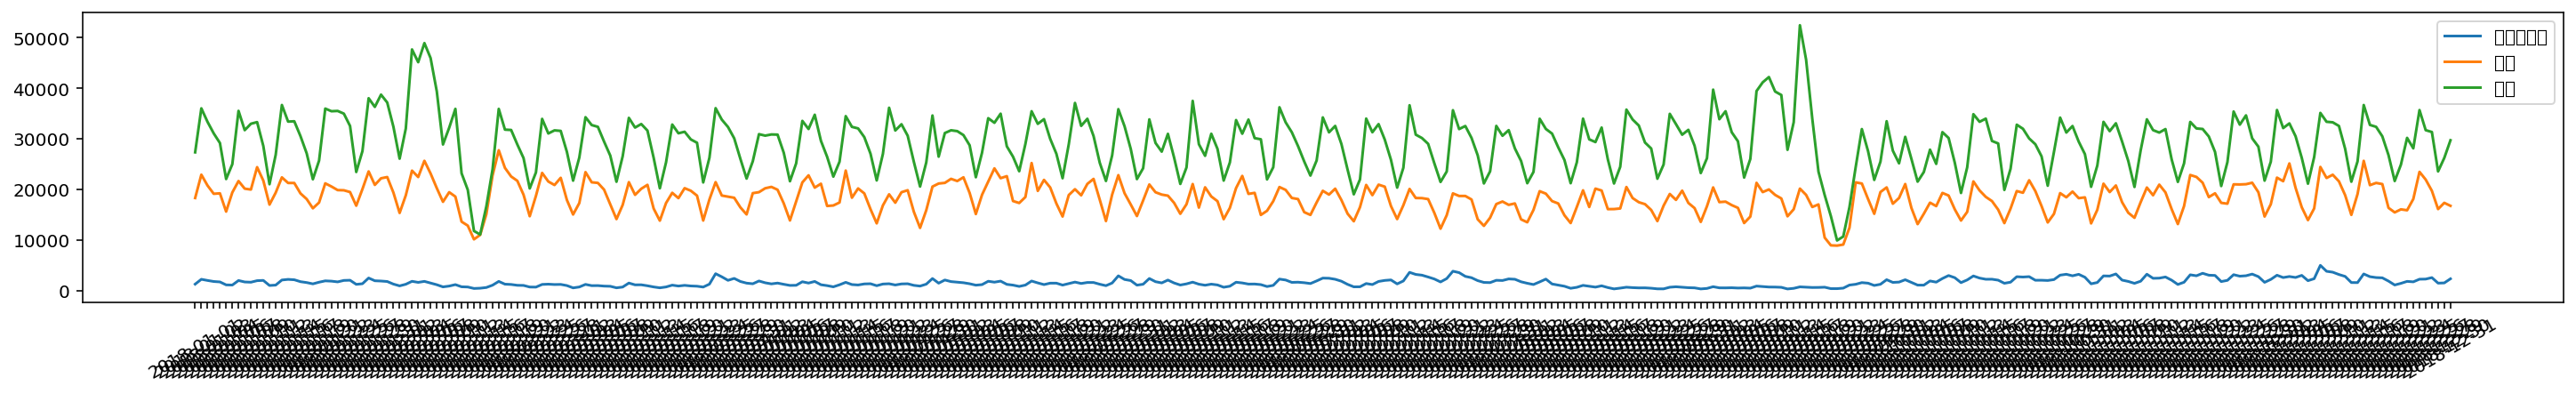

In [40]:
# 그래프 그리려다 실패한 코드
plt.figure(figsize=(25, 3))
plt.plot(day_range, buy_home, label='냉난방가전')
plt.plot(day_range, buy_beauty, label='뷰티')
plt.plot(day_range, buy_food, label='식품')
plt.legend()
plt.xticks(day_range, rotation=30)
plt.show()
# ..? 날짜 뭔디... 왜저래..

## 일별 구매현황??  
### 대분류

In [41]:
import operator

buy_home = map(operator.add, buy_home_f, buy_home_m)
buy_beauty = map(operator.add, buy_beauty_f, buy_beauty_m)
buy_food = map(operator.add, buy_food_f, buy_food_m)
buy_home = list(buy_home)
buy_beauty = list(buy_beauty)
buy_food = list(buy_food)

In [42]:
# 도훈님 그래프 훔쳐옴ㅎㅎ,,
trace1 = go.Scatter(x = day_range, y=buy_home, mode='lines+markers', name='냉난방가전')
trace2 = go.Scatter(x = day_range, y=buy_beauty, mode='lines+markers', name='뷰티')
trace3 = go.Scatter(x = day_range, y=buy_food, mode='lines+markers', name='식품')

data = [trace1, trace2, trace3]

layout = go.Layout(title='< 일별 대분류별 구매율 >')
fig = go.Figure(data, layout=layout)
fig.show()

In [43]:
# 냉난방가전만 따로 확인
trace1 = go.Scatter(x = day_range, y=buy_home, mode='lines+markers', name='냉난방가전')

data = [trace1]

layout = go.Layout(title='< 일별 냉난방가전 구매율 >')
fig = go.Figure(data, layout=layout)
fig = go.Figure(data)
fig.show()

제대로 한 게 맞나..?.. 맞다면

1. **뷰티, 식품** > 대체로 휴일(주말, 공휴일 등)의 구매율↓  
  : 놀러가서 사먹고.. 하느라 온라인 쇼핑률이 낮아지나?
2. **냉난방가전** > 5월 26일부터 31일까지 눈에 띄게 구매율 증가, 8&9월 구매율 ↓  
  : 다른 데이터에 비해 적어서 따로 확인  
  

## 성별별 구매율
### 2018년 전체

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


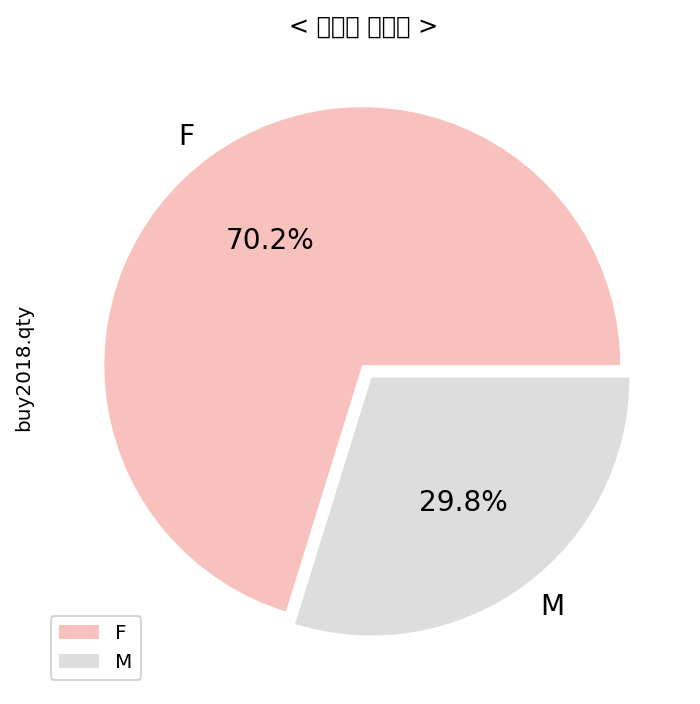

In [44]:
buy2018_sex = buy_data2018[ ['buy2018.sex', 'buy2018.qty'] ].groupby( ['buy2018.sex'] ).sum()

buy2018_sex.plot(kind = 'pie', subplots=True, explode=[0.01,0.05], autopct='%1.1f%%', colors=['#F9C1BD', '#DDDDDD'], figsize=(5,5), fontsize = 14)

plt.title('< 성별별 구매율 >')
plt.tight_layout()  # 그래프 사이 간격 자동 조정
plt.show()

2018년 전체 구매 비율은 여성이 2.3배 높다

### 일별, 대분류별 구매율
#### 여성

In [45]:
trace1 = go.Scatter(x = day_range, y=result_big_cat_f['냉난방가전'], mode='lines+markers', name='냉난방가전')
trace2 = go.Scatter(x = day_range, y=result_big_cat_f['뷰티'], mode='lines+markers', name='뷰티')
trace3 = go.Scatter(x = day_range, y=result_big_cat_f['식품'], mode='lines+markers', name='식품')

data = [trace1, trace2, trace3]

layout = go.Layout(title='< 여성 구매율 >')
fig = go.Figure(data, layout=layout)
fig.show()

#### 남성

In [46]:
trace1 = go.Scatter(x = day_range, y=result_big_cat_m['냉난방가전'], mode='lines+markers', name='냉난방가전')
trace2 = go.Scatter(x = day_range, y=result_big_cat_m['뷰티'], mode='lines+markers', name='뷰티')
trace3 = go.Scatter(x = day_range, y=result_big_cat_m['식품'], mode='lines+markers', name='식품')

data = [trace1, trace2, trace3]

layout = go.Layout(title='< 남성 구매율 >')
fig = go.Figure(data, layout=layout)
fig.show()

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


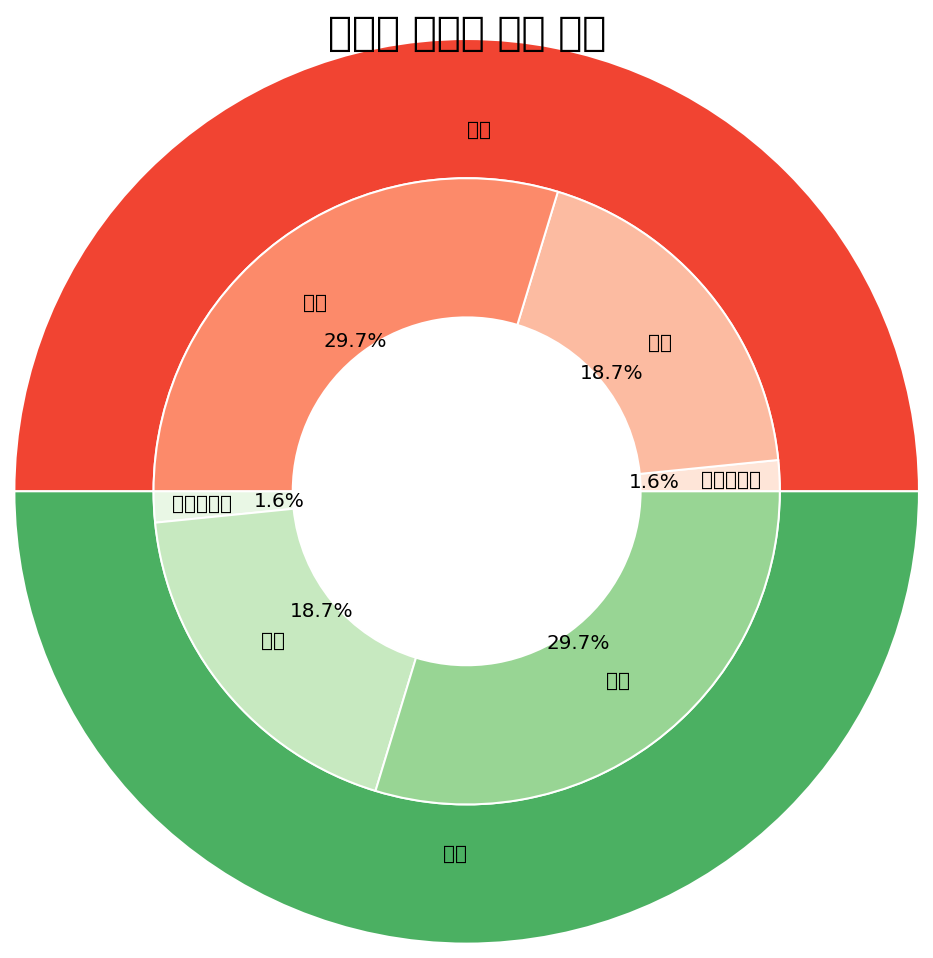

In [47]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]

# info. of groups
group_names = ['여자', '남자']
group_sizes = [result_big_cat_f['냉난방가전'].sum() + result_big_cat_f['뷰티'].sum() + result_big_cat_f['식품'].sum(),
               result_big_cat_m['냉난방가전'].sum() + result_big_cat_m['뷰티'].sum() + result_big_cat_m['식품'].sum()]

# info. of subgroups
subgroup_names = ['냉난방가전', '뷰티', '식품', 
                  '냉난방가전', '뷰티', '식품']
subgroup_sizes = [result_big_cat_f['냉난방가전'].sum(), result_big_cat_f['뷰티'].sum(), result_big_cat_f['식품'].sum(),
                  result_big_cat_m['냉난방가전'].sum(), result_big_cat_m['뷰티'].sum(), result_big_cat_m['식품'].sum()]

# colors
a, b = [plt.cm.Reds, plt.cm.Greens]

# width
width_num = 0.4


# Outside Ring
fig, ax = plt.subplots()
ax.axis('equal')
pie_outside, _ = ax.pie(group_sizes, 
                        radius=1.3, 
                        labels=group_names, 
                        labeldistance=0.8,
                        colors=[a(0.6), b(0.6)])
plt.setp(pie_outside, 
         width=width_num, 
         edgecolor='white')

# Inside Ring
pie_inside, plt_labels, junk = \
    ax.pie(subgroup_sizes, 
           radius=(1.3 - width_num), 
           labels=subgroup_names, 
           labeldistance=0.75, 
           autopct='%1.1f%%', 
           colors=[a(0.1), a(0.25), a(0.4), b(0.1), 
                   b(0.25), b(0.4)])
plt.setp(pie_inside, 
         width=width_num, 
         edgecolor='white')
plt.title('성별별 대분류 구매 비율', fontsize=20)
plt.show()